训练数据形状: (16800, 12), 测试数据形状: (4200, 12)
排名类别映射: {'Top 10': 0, 'Top 100': 1, 'Top 200': 2, 'Top 50': 3}

请选择操作模式:
1. 训练新模型
2. 加载现有模型
3. 退出


请输入选择 (1-3):  2


模型加载成功!

可用游戏列表:
1. .hack//G.U. Last Recode
2. 20 Minutes Till Dawn
3. 2XKO
4. 60 Parsecs!
5. 60 Seconds!
6. 60 Seconds! Reatomized
7. 7 Days to Die
8. <U+014C>kami
9. A Dance of Fire and Ice
10. A Difficult Game About Climbing
11. A Hat in Time
12. A Plague Tale: Innocence
13. A Plague Tale: Requiem
14. A Total War Saga: Troy
15. A Way Out
16. Abandon Ship
17. Abiotic Factor
18. Absolver
19. ABZ<U+00DB>
20. Ace Combat 7: Skies Unknown
21. AFK Journey
22. Against the Storm
23. Agar.io
24. Age of Darkness: Final Stand
25. Age of Empires
26. Age of Empires II
27. Age of Empires II: Definitive Edition
28. Age of Empires II: HD Edition
29. Age of Empires IV
30. Age of Empires: Definitive Edition
31. Age of Mythology
32. Age of Wonders 4
33. Age of Wonders: Planetfall
34. Agents of Mayhem
35. Agony
36. Agrou
37. AI: The Somnium Files
38. Aim Gods
39. Aion
40. Aion Classic
41. Alan Wake II
42. Alan Wake Remastered
43. Albion Online
44. Alien: Isolation
45. Aliens: Dark Descent
46. Aliens: Fi


请输入游戏编号 (1-2334):  1023

请输入要预测的月数 (1-12):  12



您选择了: League of Legends
预测未来 12 个月的排名
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


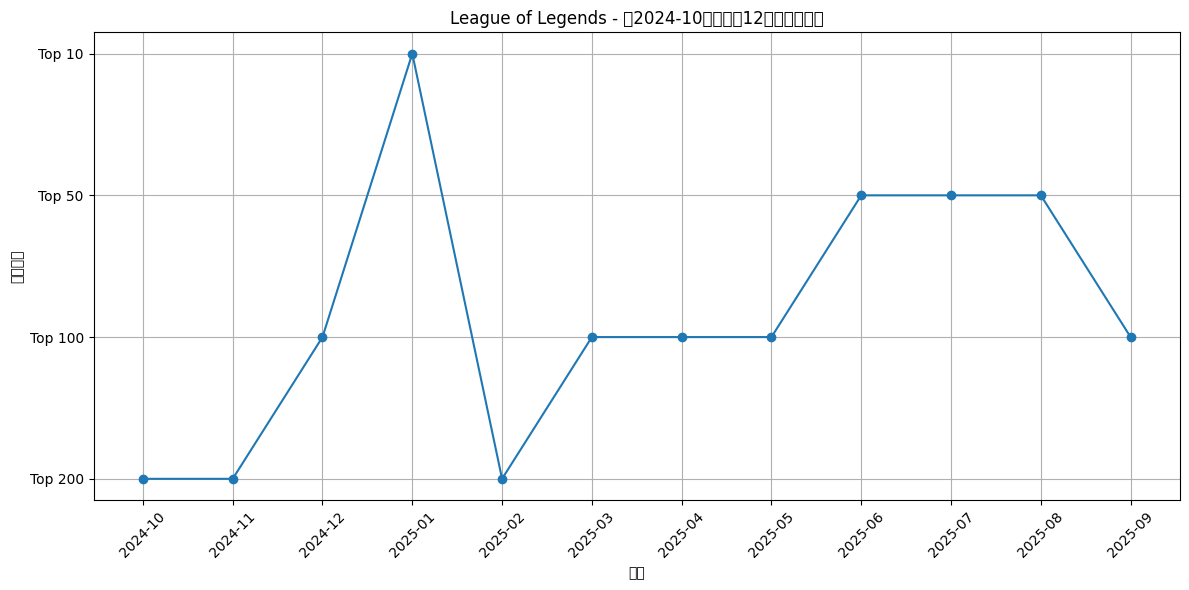


预测结果:
       Date Predicted_Rank_Category
0   2024-10                 Top 200
1   2024-11                 Top 200
2   2024-12                 Top 100
3   2025-01                  Top 10
4   2025-02                 Top 200
5   2025-03                 Top 100
6   2025-04                 Top 100
7   2025-05                 Top 100
8   2025-06                  Top 50
9   2025-07                  Top 50
10  2025-08                  Top 50
11  2025-09                 Top 100



是否继续预测其他游戏? (y/n):  y



可用游戏列表:
1. .hack//G.U. Last Recode
2. 20 Minutes Till Dawn
3. 2XKO
4. 60 Parsecs!
5. 60 Seconds!
6. 60 Seconds! Reatomized
7. 7 Days to Die
8. <U+014C>kami
9. A Dance of Fire and Ice
10. A Difficult Game About Climbing
11. A Hat in Time
12. A Plague Tale: Innocence
13. A Plague Tale: Requiem
14. A Total War Saga: Troy
15. A Way Out
16. Abandon Ship
17. Abiotic Factor
18. Absolver
19. ABZ<U+00DB>
20. Ace Combat 7: Skies Unknown
21. AFK Journey
22. Against the Storm
23. Agar.io
24. Age of Darkness: Final Stand
25. Age of Empires
26. Age of Empires II
27. Age of Empires II: Definitive Edition
28. Age of Empires II: HD Edition
29. Age of Empires IV
30. Age of Empires: Definitive Edition
31. Age of Mythology
32. Age of Wonders 4
33. Age of Wonders: Planetfall
34. Agents of Mayhem
35. Agony
36. Agrou
37. AI: The Somnium Files
38. Aim Gods
39. Aion
40. Aion Classic
41. Alan Wake II
42. Alan Wake Remastered
43. Albion Online
44. Alien: Isolation
45. Aliens: Dark Descent
46. Aliens: Fireteam E


请输入游戏编号 (1-2334):  20

请输入要预测的月数 (1-12):  12



您选择了: Ace Combat 7: Skies Unknown
预测未来 12 个月的排名
游戏 Ace Combat 7: Skies Unknown 的历史数据不足 6 个月，无法预测



是否继续预测其他游戏? (y/n):  n



请选择操作模式:
1. 训练新模型
2. 加载现有模型
3. 退出


请输入选择 (1-3):  3


退出程序。


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

# 1. 加载数据
def load_data():
    train_data = pd.read_csv('train_data.csv')
    test_data = pd.read_csv('test_data.csv')
    
    print(f"训练数据形状: {train_data.shape}, 测试数据形状: {test_data.shape}")
    return train_data, test_data

# 2. 创建排名类别标签
def create_rank_categories(df):
    conditions = [
        (df['Rank'] <= 10),
        (df['Rank'] <= 50) & (df['Rank'] > 10),
        (df['Rank'] <= 100) & (df['Rank'] > 50),
        (df['Rank'] <= 200) & (df['Rank'] > 100)
    ]
    choices = ['Top 10', 'Top 50', 'Top 100', 'Top 200']
    df['Rank_Category'] = np.select(conditions, choices, default='Other')
    
    # 对类别进行编码
    label_encoder = LabelEncoder()
    df['Rank_Category_Encoded'] = label_encoder.fit_transform(df['Rank_Category'])
    
    # 保存编码映射，用于解释预测结果
    category_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    reverse_mapping = {v: k for k, v in category_mapping.items()}
    
    return df, label_encoder, category_mapping, reverse_mapping

# 3. 特征工程
def feature_engineering(train_df, test_df):
    # 创建时间特征
    for df in [train_df, test_df]:
        # 转换为时间戳（从2016年1月开始计算）
        df['time_idx'] = (df['Year'] - 2016) * 12 + df['Month'] - 1
        
        # 添加季节性特征
        df['sin_month'] = np.sin(2 * np.pi * df['Month']/12)
        df['cos_month'] = np.cos(2 * np.pi * df['Month']/12)
    
    return train_df, test_df

# 4. 数据预处理和标准化
def preprocess_data(train_df, test_df):
    # 选择特征
    feature_columns = [
        'Hours_watched', 'Hours_streamed', 'Peak_viewers', 'Peak_channels', 
        'Streamers', 'Avg_viewers', 'Avg_channels', 'Avg_viewer_ratio',
        'time_idx', 'sin_month', 'cos_month'
    ]
    
    # 数值特征标准化
    scaler = MinMaxScaler()
    train_df[feature_columns] = scaler.fit_transform(train_df[feature_columns])
    test_df[feature_columns] = scaler.transform(test_df[feature_columns])
    
    return train_df, test_df, feature_columns, scaler

# 5. 创建序列数据
def create_sequences(df, games, feature_columns, sequence_length=6, forecast_horizon=12):
    """
    为每个游戏创建序列数据，用过去sequence_length个月的数据预测接下来的forecast_horizon个月
    """
    X, y = [], []
    game_indices = []
    
    for game in games:
        game_data = df[df['Game'] == game].sort_values('time_idx')
        
        if len(game_data) < sequence_length + forecast_horizon:
            continue  # 跳过数据不足的游戏
        
        for i in range(len(game_data) - sequence_length - forecast_horizon + 1):
            X_sequence = game_data.iloc[i:i+sequence_length][feature_columns].values
            y_sequence = game_data.iloc[i+sequence_length:i+sequence_length+forecast_horizon]['Rank_Category_Encoded'].values
            
            X.append(X_sequence)
            y.append(y_sequence)
            game_indices.append(game)
    
    return np.array(X), np.array(y), game_indices

# 6. 构建LSTM模型
def build_lstm_model(input_shape, num_classes, forecast_horizon):
    model = Sequential([
        LSTM(128, activation='relu', return_sequences=True, input_shape=input_shape),
        Dropout(0.3),
        LSTM(64, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(forecast_horizon * num_classes, activation='linear')
    ])
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# 7. 训练模型
def train_model(X_train, y_train, X_val, y_val, num_classes, forecast_horizon):
    # 调整y的形状以适应多输出分类
    y_train_reshaped = np.zeros((y_train.shape[0], forecast_horizon, num_classes))
    for i in range(y_train.shape[0]):
        for j in range(forecast_horizon):
            if j < y_train.shape[1]:  # 确保不超出边界
                y_train_reshaped[i, j, y_train[i, j]] = 1
                
    y_val_reshaped = np.zeros((y_val.shape[0], forecast_horizon, num_classes))
    for i in range(y_val.shape[0]):
        for j in range(forecast_horizon):
            if j < y_val.shape[1]:  # 确保不超出边界
                y_val_reshaped[i, j, y_val[i, j]] = 1
    
    # 调整形状以适应LSTM输入
    y_train_reshaped = y_train_reshaped.reshape(y_train.shape[0], -1)
    y_val_reshaped = y_val_reshaped.reshape(y_val.shape[0], -1)
    
    # 构建模型
    input_shape = (X_train.shape[1], X_train.shape[2])
    model = build_lstm_model(input_shape, num_classes, forecast_horizon)
    
    # 设置早停
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )
    
    # 训练模型
    history = model.fit(
        X_train, y_train_reshaped,
        epochs=50,
        batch_size=32,
        validation_data=(X_val, y_val_reshaped),
        callbacks=[early_stopping],
        verbose=1
    )
    
    return model, history

# 8. 评估和预测
def evaluate_model(model, X_test, y_test, num_classes, forecast_horizon, reverse_mapping):
    # 预测
    y_pred_proba = model.predict(X_test)
    
    # 重塑预测结果
    y_pred_proba = y_pred_proba.reshape(y_pred_proba.shape[0], forecast_horizon, num_classes)
    y_pred = np.argmax(y_pred_proba, axis=2)
    
    # 计算准确率和RMSE
    accuracies = []
    rmse_values = []
    for month in range(min(forecast_horizon, y_test.shape[1])):
        # 准确率 (分类指标)
        acc = accuracy_score(y_test[:, month], y_pred[:, month])
        accuracies.append(acc)
        
        # RMSE (回归指标)
        # 将类别值视为连续值 (0, 1, 2, 3) 计算RMSE
        rmse = np.sqrt(np.mean((y_test[:, month] - y_pred[:, month])**2))
        rmse_values.append(rmse)
        
        print(f"第 {month+1} 个月的预测准确率: {acc:.4f}, RMSE: {rmse:.4f}")
    
    # 可视化准确率和RMSE随预测时间变化
    plt.figure(figsize=(15, 6))
    
    # 准确率图
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(accuracies) + 1), accuracies, marker='o', color='blue')
    plt.title('预测准确率随时间变化')
    plt.xlabel('预测月数')
    plt.ylabel('准确率')
    plt.grid(True)
    
    # RMSE图
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(rmse_values) + 1), rmse_values, marker='o', color='red')
    plt.title('RMSE随时间变化')
    plt.xlabel('预测月数')
    plt.ylabel('RMSE')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # 为第一个月的预测结果绘制混淆矩阵
    if y_test.shape[1] > 0:
        cm = confusion_matrix(y_test[:, 0], y_pred[:, 0])
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=[reverse_mapping[i] for i in range(num_classes)],
                   yticklabels=[reverse_mapping[i] for i in range(num_classes)])
        plt.title('第一个月预测的混淆矩阵')
        plt.ylabel('真实类别')
        plt.xlabel('预测类别')
        plt.show()
    
    # 计算平均准确率和RMSE
    avg_accuracy = np.mean(accuracies)
    avg_rmse = np.mean(rmse_values)
    print(f"\n平均准确率: {avg_accuracy:.4f}, 平均RMSE: {avg_rmse:.4f}")
    
    # 计算并显示预测前6个月的整体指标
    if len(accuracies) >= 6:
        print(f"前6个月平均准确率: {np.mean(accuracies[:6]):.4f}, 前6个月平均RMSE: {np.mean(rmse_values[:6]):.4f}")
    
    return y_pred, accuracies, rmse_values

# 9. 对特定游戏进行预测
def predict_for_game(model, game_name, train_df, test_df, feature_columns, scaler, sequence_length, 
                    forecast_horizon, num_classes, reverse_mapping):
    """预测游戏未来排名，使用最新的数据（包括测试集数据）"""
    # 合并训练和测试数据以获取最新的游戏数据
    combined_df = pd.concat([train_df, test_df])
    game_data = combined_df[combined_df['Game'] == game_name].sort_values('time_idx')
    
    if len(game_data) < sequence_length:
        print(f"游戏 {game_name} 的历史数据不足 {sequence_length} 个月，无法预测")
        return None
    
    # 获取最近的数据点（使用最后sequence_length个月的数据）
    recent_data = game_data.iloc[-sequence_length:][feature_columns].values
    recent_data = recent_data.reshape(1, sequence_length, len(feature_columns))
    
    # 预测
    prediction = model.predict(recent_data)
    prediction = prediction.reshape(1, forecast_horizon, num_classes)
    prediction_classes = np.argmax(prediction, axis=2)[0]
    
    # 转换为类别名称
    prediction_categories = [reverse_mapping[pred] for pred in prediction_classes]
    
    # 获取最后一个日期（应该是2023年12月或最新的数据点）
    last_record = game_data.iloc[-1]
    last_month = last_record['Month']
    last_year = last_record['Year']
    
    # 计算未来月份，从最后一个月开始
    future_dates = []
    for i in range(forecast_horizon):
        future_month = (last_month + i) % 12 + 1  # 1-12
        future_year = last_year + (last_month + i) // 12
        future_dates.append(f"{future_year}-{future_month:02d}")
    
    # 创建预测结果DataFrame
    results = pd.DataFrame({
        'Date': future_dates,
        'Predicted_Rank_Category': prediction_categories
    })
    
    # 可视化预测结果
    plt.figure(figsize=(12, 6))
    category_values = {'Top 10': 4, 'Top 50': 3, 'Top 100': 2, 'Top 200': 1}
    result_values = [category_values[cat] for cat in prediction_categories]
    
    plt.plot(future_dates, result_values, marker='o', linestyle='-')
    plt.title(f'{game_name} - 从{future_dates[0]}开始未来{forecast_horizon}个月排名预测')
    plt.xlabel('日期')
    plt.ylabel('排名类别')
    plt.yticks([1, 2, 3, 4], ['Top 200', 'Top 100', 'Top 50', 'Top 10'])
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return results

# 10. 用户交互函数
def user_interaction(train_data, test_data, model=None):
    """允许用户选择游戏和预测月数，并显示预测结果"""
    
    # 获取所有可用的游戏列表并标准化处理
    game_set = set()
    game_map = {}  # 用于映射显示名称到原始名称
    
    # 处理训练集游戏
    for game in train_data['Game'].unique():
        if pd.isna(game):
            continue
            
        if isinstance(game, (int, float)):
            game = str(game)
            
        # 使用小写版本作为标识符，避免大小写导致的重复
        game_lower = game.lower()
        if game_lower not in game_set:
            game_set.add(game_lower)
            game_map[game_lower] = game  # 保存原始大小写
    
    # 处理测试集游戏        
    for game in test_data['Game'].unique():
        if pd.isna(game):
            continue
            
        if isinstance(game, (int, float)):
            game = str(game)
            
        game_lower = game.lower()
        if game_lower not in game_set:
            game_set.add(game_lower)
            game_map[game_lower] = game
    
    # 获取排序后的唯一游戏列表（使用原始大小写显示）
    all_games_lower = sorted(game_set)
    all_games = [game_map[game_lower] for game_lower in all_games_lower]
    
    # Display game list
    print("\n可用游戏列表:")
    for i, game in enumerate(all_games):
        print(f"{i+1}. {game}")
    
    # Let user select game
    while True:
        try:
            choice = int(input("\n请输入游戏编号 (1-{}): ".format(len(all_games))))
            if 1 <= choice <= len(all_games):
                selected_game = all_games[choice-1]
                break
            else:
                print("无效的选择，请重新输入。")
        except ValueError:
            print("请输入有效的数字。")
    
    # Let user select forecast months
    while True:
        try:
            forecast_months = int(input("\n请输入要预测的月数 (1-12): "))
            if 1 <= forecast_months <= 12:
                break
            else:
                print("请输入1到12之间的数字。")
        except ValueError:
            print("请输入有效的数字。")
    
    print(f"\n您选择了: {selected_game}")
    print(f"预测未来 {forecast_months} 个月的排名")
    
    return selected_game, forecast_months

# 11. 主函数
def main():
    # 加载数据
    train_data, test_data = load_data()
    
    # 创建排名类别
    train_data, label_encoder, category_mapping, reverse_mapping = create_rank_categories(train_data)
    test_data, _, _, _ = create_rank_categories(test_data)
    
    print("排名类别映射:", category_mapping)
    num_classes = len(category_mapping)
    
    # 特征工程
    train_data, test_data = feature_engineering(train_data, test_data)
    
    # 数据预处理
    train_data, test_data, feature_columns, scaler = preprocess_data(train_data, test_data)
    
    # 选择操作模式
    while True:
        print("\n请选择操作模式:")
        print("1. 训练新模型")
        print("2. 加载现有模型")
        print("3. 退出")
        
        choice = input("请输入选择 (1-3): ")
        
        if choice == '1':
            # 设置序列长度和预测范围
            sequence_length = 6  # 使用过去6个月的数据
            forecast_horizon = 12  # 预测未来12个月
            
            # 获取所有游戏名称
            games = train_data['Game'].unique()
            
            # 创建序列数据
            print("\n正在准备训练数据...")
            X, y, game_indices = create_sequences(
                train_data, games, feature_columns, 
                sequence_length, forecast_horizon
            )
            
            print(f"创建的序列数据: X shape = {X.shape}, y shape = {y.shape}")
            
            # 分割训练集和验证集
            X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
            
            # 训练模型
            print("\n开始训练模型...")
            model, history = train_model(X_train, y_train, X_val, y_val, num_classes, forecast_horizon)
            
            # 可视化训练历史
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(history.history['loss'])
            plt.plot(history.history['val_loss'])
            plt.title('模型损失')
            plt.ylabel('损失')
            plt.xlabel('训练轮次')
            plt.legend(['训练', '验证'], loc='upper right')
            
            plt.subplot(1, 2, 2)
            plt.plot(history.history['accuracy'])
            plt.plot(history.history['val_accuracy'])
            plt.title('模型准确率')
            plt.ylabel('准确率')
            plt.xlabel('训练轮次')
            plt.legend(['训练', '验证'], loc='lower right')
            plt.tight_layout()
            plt.show()
            
            # 评估模型
            print("\n验证集评估:")
            y_val_pred, val_accuracies, val_rmse_values = evaluate_model(
                model, X_val, y_val, num_classes, forecast_horizon, reverse_mapping
            )
            
            # 为测试集准备数据
            test_games = test_data['Game'].unique()
            X_test, y_test, test_game_indices = create_sequences(
                test_data, test_games, feature_columns,
                sequence_length, forecast_horizon
            )
            
            if len(X_test) > 0:
                print("\n测试集评估:")
                y_test_pred, test_accuracies, test_rmse_values = evaluate_model(
                    model, X_test, y_test, num_classes, forecast_horizon, reverse_mapping
                )
            
            # 保存模型
            model.save('game_rank_lstm_model.h5')
            print("\n模型已保存为 'game_rank_lstm_model.h5'")
            
            # 用户交互预测部分
            while True:
                # 让用户选择游戏和预测月数
                selected_game, forecast_months = user_interaction(train_data, test_data)
                
                # 查找训练数据中是否存在这个游戏（不区分大小写）
                train_games_lower = [g.lower() if isinstance(g, str) else str(g).lower() for g in train_data['Game'].unique()]
                selected_game_lower = selected_game.lower()
                
                if selected_game_lower in train_games_lower:
                    # 找到原始大小写的游戏名
                    original_games = train_data['Game'].unique()
                    for g in original_games:
                        if isinstance(g, str) and g.lower() == selected_game_lower:
                            original_game = g
                            break
                        elif not isinstance(g, str) and str(g).lower() == selected_game_lower:
                            original_game = g
                            break
                    
                    # 进行预测
                    try:
                        prediction = predict_for_game(
                            model, original_game, train_data, test_data, feature_columns, scaler,
                            sequence_length, forecast_months, num_classes, reverse_mapping
                        )
                        
                        if prediction is not None:
                            print("\n预测结果:")
                            print(prediction)
                    except Exception as e:
                        print(f"预测出错: {e}")
                else:
                    print(f"警告：游戏 '{selected_game}' 在训练数据中不存在，无法预测。")
                
                continue_prediction = input("\n是否继续预测其他游戏? (y/n): ")
                if continue_prediction.lower() != 'y':
                    break
            
        elif choice == '2':
            # 加载现有模型
            try:
                from tensorflow.keras.models import load_model
                model = load_model('game_rank_lstm_model.h5')
                print("模型加载成功!")
                
                # 设置序列长度和预测范围
                sequence_length = 6  # 使用过去6个月的数据
                
                # 用户交互预测部分
                while True:
                    # 让用户选择游戏和预测月数
                    selected_game, forecast_months = user_interaction(train_data, test_data, model)
                    
                    # 查找训练数据中是否存在这个游戏（不区分大小写）
                    train_games_lower = [g.lower() if isinstance(g, str) else str(g).lower() for g in train_data['Game'].unique()]
                    selected_game_lower = selected_game.lower()
                    
                    if selected_game_lower in train_games_lower:
                        # 找到原始大小写的游戏名
                        original_games = train_data['Game'].unique()
                        for g in original_games:
                            if isinstance(g, str) and g.lower() == selected_game_lower:
                                original_game = g
                                break
                            elif not isinstance(g, str) and str(g).lower() == selected_game_lower:
                                original_game = g
                                break
                        
                        # 进行预测
                        try:
                            prediction = predict_for_game(
                                model, original_game, train_data, test_data, feature_columns, scaler,
                                sequence_length, forecast_months, num_classes, reverse_mapping
                            )
                            
                            if prediction is not None:
                                print("\n预测结果:")
                                print(prediction)
                        except Exception as e:
                            print(f"预测出错: {e}")
                    else:
                        print(f"警告：游戏 '{selected_game}' 在训练数据中不存在，无法预测。")
                    
                    continue_prediction = input("\n是否继续预测其他游戏? (y/n): ")
                    if continue_prediction.lower() != 'y':
                        break
                
            except Exception as e:
                print(f"加载模型出错: {e}")
                print("请先训练模型或确保模型文件存在。")
        
        elif choice == '3':
            print("退出程序。")
            break
        
        else:
            print("无效选择，请重新输入。")

if __name__ == "__main__":
    main()